In [3]:
# Our objective is to identify customer groups within the data to 
# target these customers with solutions to engage them back or continue them in the company. We will first use an RFM model before
# transitioning into a KMeans algorithm to identify natural clusters in the data.

In [5]:
# Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [6]:
df = pd.read_csv(r'/Users/joebeadles/Desktop/OnlineRetail.csv')

In [7]:
print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (541909, 8)


In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [13]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [15]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [19]:
# CLEANING

In [21]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [23]:
df = df.dropna(subset=['Description'])
df = df.dropna(subset=['CustomerID'])
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [25]:
# It is very possible that all of our null value description rows were linked to rows with a null CustomerID
df.isna().sum()
df.shape

(406829, 8)

In [27]:
# Due to the sheer amount of data involved in this dataset, I decided to drop the null CustomerID values and create a balanced dataset

In [29]:
# This counts the total number of unique rows in our dataset so we can see that we have 5225 duplicate rows
duplicate_total = len(df.drop_duplicates())
print("Total number of duplicates:", duplicate_total)

Total number of duplicates: 401604


In [31]:
df = df.drop_duplicates()
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerID         Country  
0        1

In [33]:
# Earlier we identified negative values in these columns, lets check to see how many we are dealing with.
negative_quantity = df.loc[df['Quantity'] < 0]
print("Number of negative Quantity:", len(negative_quantity))

negative_unitprice = df.loc[df['UnitPrice'] < 0]
print("Number of negative Unit Prices:", len(negative_unitprice))

Number of negative Quantity: 8872
Number of negative Unit Prices: 0


In [35]:
# Dropping negative quantities from these columns
df = df[df['Quantity'] >= 0]

df = df[df['UnitPrice'] >= 0]

In [37]:
# Double checking our work
negative_quantity = df.loc[df['Quantity'] < 0]
print("Number of negative Quantity:", len(negative_quantity))

negative_unitprice = df.loc[df['UnitPrice'] < 0]
print("Number of negative unit prices:", len(negative_unitprice))

Number of negative Quantity: 0
Number of negative unit prices: 0


In [39]:
# CustomerID is not a float, lets change it to int
df['CustomerID'] = df['CustomerID'].astype(int)
print(df['CustomerID'])

0         17850
1         17850
2         17850
3         17850
4         17850
          ...  
541904    12680
541905    12680
541906    12680
541907    12680
541908    12680
Name: CustomerID, Length: 392732, dtype: int64


In [41]:
# Identifying if we need to standardize any Country values
unique_country = df['Country'].unique()
print(unique_country)

['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Finland' 'Austria' 'Greece' 'Singapore' 'Lebanon'
 'United Arab Emirates' 'Israel' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Unspecified' 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'RSA']


In [43]:
# TRANSFORMATION

In [45]:
# Converting InvoiceDate into a date and separating the date and the time into two separate columns
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['DateInvoice'] = df['InvoiceDate'].dt.date

df['InvoiceTime'] = df['InvoiceDate'].dt.time

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  int64         
 7   Country      392732 non-null  object        
 8   DateInvoice  392732 non-null  object        
 9   InvoiceTime  392732 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 33.0+ MB
None


In [47]:
# Converting these columns into the correct data types, additionally creating a year column
df['DateInvoice'] = df['DateInvoice'].astype('datetime64[ns]')

df['InvoiceYear'] = df['DateInvoice'].dt.year

df['InvoiceYear'] = df['InvoiceYear'].astype('int')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  int64         
 7   Country      392732 non-null  object        
 8   DateInvoice  392732 non-null  datetime64[ns]
 9   InvoiceTime  392732 non-null  object        
 10  InvoiceYear  392732 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 36.0+ MB


In [49]:
# Creating a revenue column after dropping the negative values
df['Revenue'] = df['UnitPrice']*df['Quantity']
print(df)
print("Total Revenue:", "$" + df['Revenue'].sum().round(2).astype(str))

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country DateInvoi

In [51]:
# Identifying the distribution of our data based on the year
counts_2010 = len(df[df['InvoiceYear'] == 2010])
counts_2011 = len(df[df['InvoiceYear'] == 2011])

print("2010 Row Count:", counts_2010)
print("2011 Row Count:", counts_2011)

row_count = len(df)

percentage_2010 = (counts_2010 / row_count) * 100
percentage_2011 = (counts_2011 / row_count) * 100

print("2010 percentage of total dataset:", f"({percentage_2010:.2f}%)")
print("2011 percentage of total dataset:", f"({percentage_2011:.2f}%)")

print("Difference in rows:", (counts_2011 - counts_2010))

2010 Row Count: 25673
2011 Row Count: 367059
2010 percentage of total dataset: (6.54%)
2011 percentage of total dataset: (93.46%)
Difference in rows: 341386


In [53]:
# Undersampling the data to balance the distribution
balanced_df = df[df['InvoiceYear'] == 2011]

drop_rows = 341386

rows_drop_df = balanced_df.sample(n=drop_rows, random_state=42)
df = df.drop(rows_drop_df.index)

print(len(df))

51346


In [55]:
# Double checking our work
counts_2010 = len(df[df['InvoiceYear'] == 2010])
counts_2011 = len(df[df['InvoiceYear'] == 2011])
print(counts_2010)
print(counts_2011)

25673
25673


In [57]:
# Handling outliers in the relevant columns
z_scores = np.abs(stats.zscore(df['Quantity']))
outliers = df[z_scores > 3]
print(len(outliers))

18


In [59]:
print("Dataset size:", len(df))

Dataset size: 51346


In [61]:
df = df[z_scores <= 3]
print("Dataset size after Quantity outliers:", len(df))

Dataset size after Quantity outliers: 51328


In [63]:
# Outliers in Unit Price
z_scores = np.abs(stats.zscore(df['UnitPrice']))
outliers_u = df[z_scores > 3]
print(len(outliers_u))

135


In [65]:
print("Dataset size:", len(df))

Dataset size: 51328


In [67]:
df = df[z_scores <= 3]
print("Dataset size after Unit Price outliers:", len(df))

Dataset size after Unit Price outliers: 51193


In [69]:
# EDA on our cleaned dataset

In [71]:
# How is yearly revenue split up?
yearly_revenue = df.groupby(df['DateInvoice'].dt.year)['Revenue'].sum().round()
print(yearly_revenue.astype(int))

DateInvoice
2010    547882
2011    533737
Name: Revenue, dtype: int64


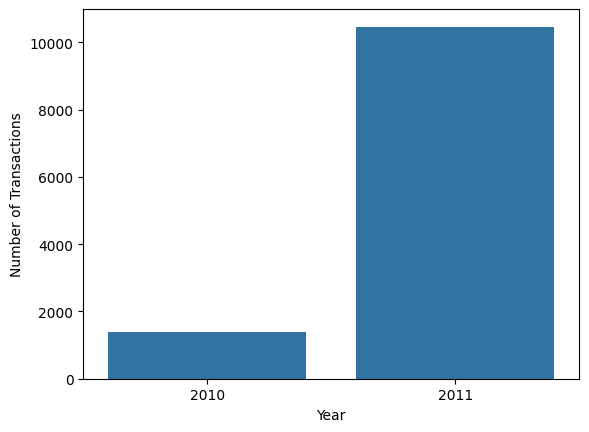

In [73]:
# Number of transactions per year
invoice_yearly = df.groupby('InvoiceYear')['InvoiceNo'].nunique().reset_index()
sns.barplot(x='InvoiceYear',y='InvoiceNo', data=invoice_yearly)
plt.xlabel('Year')
plt.ylabel('Number of Transactions')
plt.show()

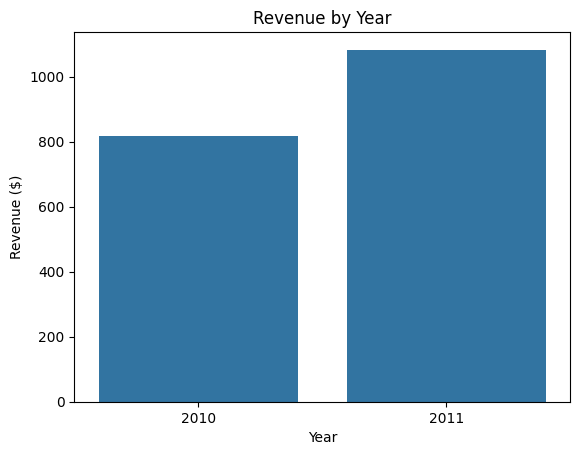

In [75]:
# Revenue per year
yearly_revenue = df.groupby('InvoiceYear')['Revenue'].nunique().reset_index()

sns.barplot(x='InvoiceYear',y='Revenue', data=yearly_revenue)
plt.title('Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Revenue ($)')
plt.show()

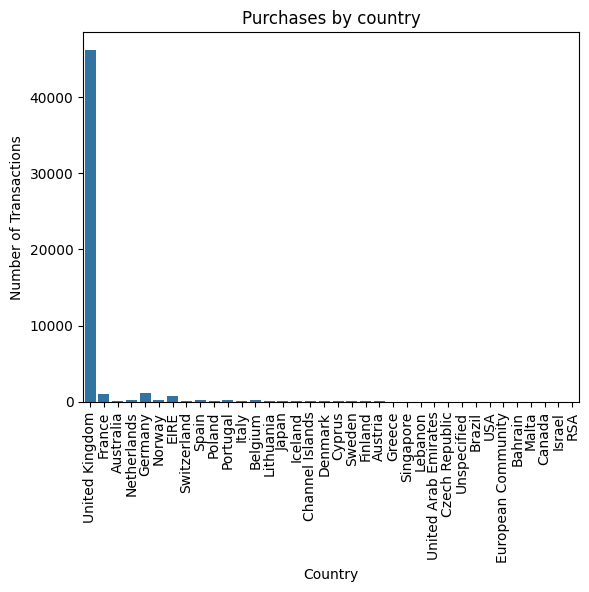

In [77]:
# Purchases by country
sns.countplot(x='Country', data=df)
plt.title('Purchases by country')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.show()

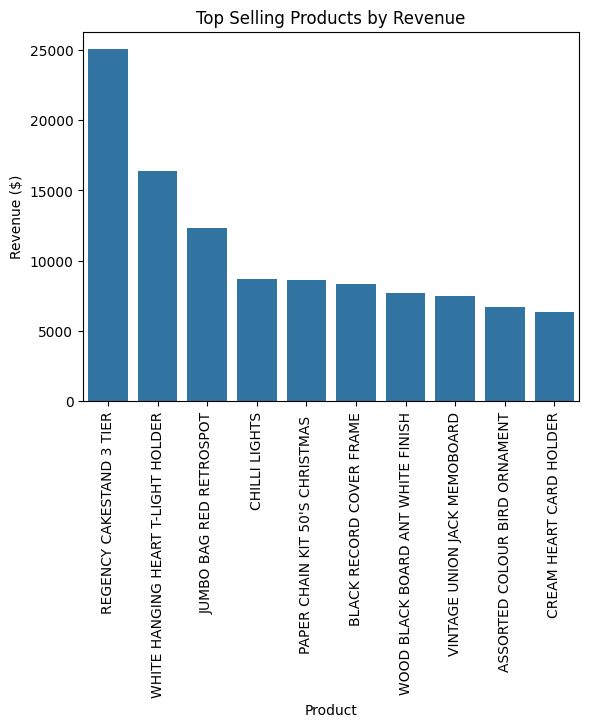

In [79]:
# Top 10 products
top_10_selling_products = df.groupby('Description')['Revenue'].sum().reset_index()
top_10_selling_products = top_10_selling_products.sort_values(by='Revenue',ascending=False).head(10)
sns.barplot(x='Description', y='Revenue', data=top_10_selling_products)
plt.xticks(rotation=90)
plt.title('Top Selling Products by Revenue')
plt.xlabel('Product')
plt.ylabel('Revenue ($)')
plt.show()

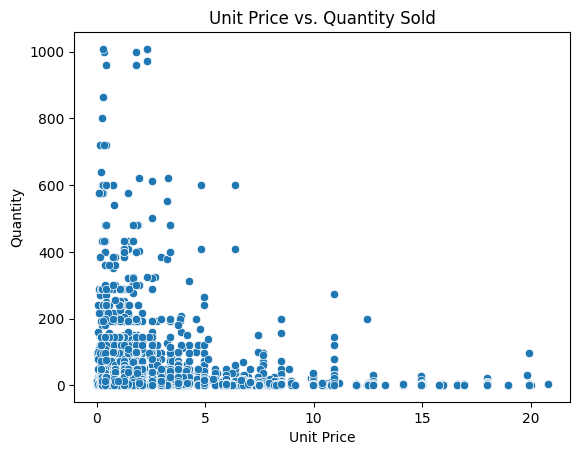

In [81]:
# Visualizing Unit Price vs Quantity
sns.scatterplot(x='UnitPrice',y='Quantity',data=df)
plt.title('Unit Price vs. Quantity Sold')
plt.xlabel('Unit Price')
plt.ylabel('Quantity')
plt.show()

In [83]:
# Now we can segment our customers based on their purchasing behavior since we do not have their age or gender.
reference_date = df['DateInvoice'].max()
rfm = df.groupby('CustomerID').agg({
    'DateInvoice': lambda x: (reference_date - x.max()).days,
    'InvoiceNo':'count',
    'Revenue':'sum'
}).rename(columns={'DateInvoice':'recency', 'InvoiceNo':'frequency','Revenue':'monetary'})
rfm = rfm.reset_index()
print(rfm.head(15))

    CustomerID  recency  frequency  monetary
0        12347        2         43    907.39
1        12348      358         16    652.80
2        12349       18          2     32.28
3        12352       72          5     84.35
4        12354      232          5     86.20
5        12355      214          1     25.50
6        12357       33          5    273.00
7        12359       57         17    313.90
8        12360       52          8    133.16
9        12361      287          2     41.10
10       12362        3         21    385.92
11       12363      109          2     47.40
12       12364        7          5     71.70
13       12365      291          2     34.70
14       12367        4          1      9.90


In [85]:
# Here we are scoring each customer on a scale of 1-5 for their recency, frequency, and monetary values
def score_rfm(df, column, bins=5):
    labels = [5,4,3,2,1]
    df[column + '_score'] = pd.qcut(df[column],q=bins, labels=labels, duplicates='drop')
    return df
rfm = score_rfm(rfm, 'recency')
rfm = score_rfm(rfm, 'frequency') 
rfm = score_rfm(rfm, 'monetary')
print(rfm[['CustomerID', 'recency', 'recency_score', 'frequency', 'frequency_score', 'monetary', 'monetary_score']].head())

   CustomerID  recency recency_score  frequency frequency_score  monetary  \
0       12347        2             5         43               1    907.39   
1       12348      358             1         16               2    652.80   
2       12349       18             4          2               5     32.28   
3       12352       72             3          5               3     84.35   
4       12354      232             1          5               3     86.20   

  monetary_score  
0              1  
1              1  
2              4  
3              3  
4              3  


In [87]:
# We can create a combined rfm_score of their values but to segment these customers we will use the individual scores
rfm['rfm_score'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str)
print(rfm.head())

   CustomerID  recency  frequency  monetary recency_score frequency_score  \
0       12347        2         43    907.39             5               1   
1       12348      358         16    652.80             1               2   
2       12349       18          2     32.28             4               5   
3       12352       72          5     84.35             3               3   
4       12354      232          5     86.20             1               3   

  monetary_score rfm_score  
0              1       511  
1              1       121  
2              4       454  
3              3       333  
4              3       133  


In [89]:
# Segmenting our customers based on their individual score columns
def rfm_segment(row):
    recency, frequency, monetary = row['recency'], row['frequency'], row['monetary']
    if recency >= 4 and frequency >= 4 and monetary >= 100:
        return 'Top Customer'
    elif recency >= 3 and frequency >= 4 and monetary >= 50:
        return 'Loyal Customer'
    elif recency >= 4 and frequency >= 2 and monetary >= 50:
        return 'Potential Loyal Customer'
    elif recency >= 4 and frequency <= 2 and monetary <= 50:
        return 'Recent Customer'
    elif recency <= 2 and frequency >= 2 and monetary <= 50:
        return 'At-Risk Customer'
    elif recency <= 2 and frequency <= 2 and monetary <= 50:
        return 'Lost Customer'
    else:
        return 'Other'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)
# Our previous aggregation shouldve made sure we had each unique CustomerID but lets be 100% sure
print(rfm[['CustomerID', 'Segment']].drop_duplicates)

<bound method DataFrame.drop_duplicates of       CustomerID                   Segment
0          12347                     Other
1          12348              Top Customer
2          12349           Recent Customer
3          12352            Loyal Customer
4          12354            Loyal Customer
...          ...                       ...
3609       18272              Top Customer
3610       18277           Recent Customer
3611       18281           Recent Customer
3612       18283            Loyal Customer
3613       18287  Potential Loyal Customer

[3614 rows x 2 columns]>


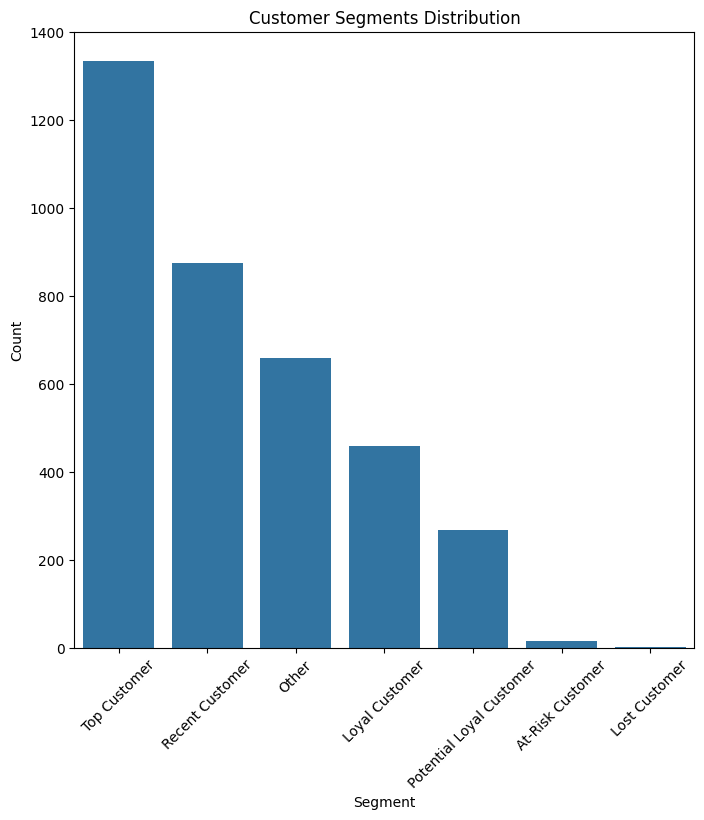

In [91]:
# Now we can visualize our distribution of customers with a countplot
plt.figure(figsize=(8,8))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [93]:
# Based on our previous segmentation, we will aggregate the customer segments
rfm_grouped = rfm.groupby('Segment').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':'mean',
    'CustomerID':'count'
}).reset_index().round(2)

print(rfm_grouped)

                    Segment  recency  frequency  monetary  CustomerID
0          At-Risk Customer     1.53       3.47     29.89          15
1             Lost Customer     0.67       1.00     13.97           3
2            Loyal Customer    79.66       9.35    191.30         458
3                     Other    86.20      14.80    285.00         659
4  Potential Loyal Customer   132.75       2.62    130.08         269
5           Recent Customer   135.35       1.39     20.65         876
6              Top Customer    94.67      26.37    564.18        1334


In [95]:
# A summary of our segments
summary = rfm.groupby('Segment')[['recency','frequency','monetary']].describe()
print(summary)

                         recency                                             \
                           count        mean         std  min    25%    50%   
Segment                                                                       
At-Risk Customer            15.0    1.533333    0.516398  1.0   1.00    2.0   
Lost Customer                3.0    0.666667    0.577350  0.0   0.50    1.0   
Loyal Customer             458.0   79.663755   88.651979  3.0  18.00   46.0   
Other                      659.0   86.198786  101.600467  0.0   9.00   43.0   
Potential Loyal Customer   269.0  132.747212  103.808391  4.0  51.00   94.0   
Recent Customer            876.0  135.353881   99.960691  4.0  48.50  113.0   
Top Customer              1334.0   94.673163  114.710051  4.0  17.25   41.0   

                                        frequency             ...        \
                             75%    max     count       mean  ...   75%   
Segment                                                    

In [97]:
# At Risk Customers: We have 15 customers in this group, with an average recency of 1.53 days (indicating they recently purchased).
# However, they had infrequent buying behavior, averaging 3.4 purchases and further have a moderate spending average of $29.89.

# Lost Customers: There were only 3 customers in this group, with low engagement. They had a recency of 0.6 days and a frequency of 1.0,
# suggesting low levels of activity. Additionally, customers in this segment spent a low average of $13.97.

# Loyal Customers: This group consisted of 458 customers with a recency score of 79.66, indicating purchases being made less recently.
# However, this group had a high frequency of 9.6 purchases, demonstrating a consistent purchasing pattern. Additionally, this group had a
# high monetary score of $191.31, showcasing the solid purchasing habits despite having made less recent purchases.

# Potential Loyal Customers: There were 269 customers in this group, characterized by past high spending ($130.08 average) but a low recency
# (132.75 day average since last purchases). Additionally, this group had a moderate frequency of 2.62 purchases.

# Recent Customers: This group consisted of 876 customers with the highest recency score of 135.35 days since the most recent purchases.
# Additionally, this group had a low monetary spend of $20.65 and a low frequency of 1.39 purchases.

# Top Customers: This was the largest group in our dataset, containing 1334 customers. This group was characterized by the highest monetary
# average of $564.18 and the highest frequency of purchases at 26.37 on average. This group has not purchased recently, having an average
# recency of 94.67 but they still contribute heavily to overall sales.

# Other Customers: This was also a significant chunk of our customers, containing 659 customers. This group had a high average monetary
# spending of $284.99 and also a moderate frequency of 14.80 purchases. Additionally, this group had a moderate average recency in comparison
# to the other groups, demonstrating an average of 86.20 days since their last purchase.

In [99]:
# One issue with our RFM segmentation is the "Recent Customers" turned out to have the highest recency score out of all the groups.
# This is paradoxical and thus we can utilize KMeans to identify natural groupings of customers within the data.

In [101]:
# Using KMeans to identify natural groupings of customers in the data
rfm_data = rfm[['recency','frequency','monetary']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(rfm_data)
print(rfm_data)

      recency  frequency  monetary
0           2         43    907.39
1         358         16    652.80
2          18          2     32.28
3          72          5     84.35
4         232          5     86.20
...       ...        ...       ...
3609       45          7    134.10
3610       58          1     12.60
3611      180          2     21.54
3612        3         41    116.51
3613       58          2     56.22

[3614 rows x 3 columns]


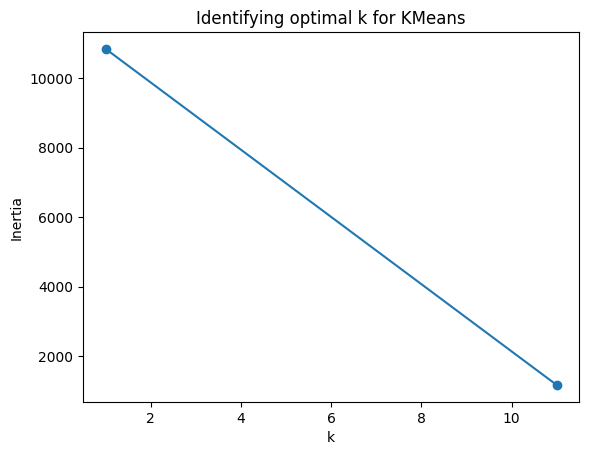

In [103]:
# Finding the optimal k using the Elbow Method
inertia = []
k_range = (1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
# This will allow us to plot each k to identify when the inertia starts to decrease and thus identifying our optimal k

plt.plot(k_range, inertia,marker='o')
plt.title('Identifying optimal k for KMeans')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [105]:
# There is no identifiable elbow in our graph, indicating that there is noise or there are no distinct clusters
# To help better identify an optimal k, we will switch to finding the silhouette scores

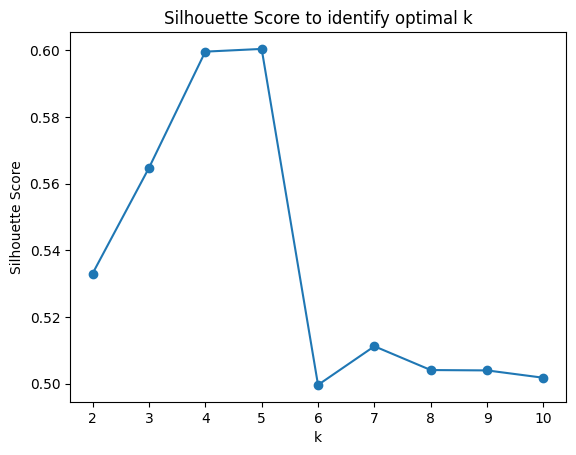

Optimal k: 5


In [107]:
# Silhouette Scores
k_range = range(2,11)

sil_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    sil_scores.append(score)

plt.plot(k_range, sil_scores, marker='o')
plt.title('Silhouette Score to identify optimal k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()

# Now lets identify k with the highest score, we can see 4 and 5 are up there.
optimal_k = k_range[sil_scores.index(max(sil_scores))]
print("Optimal k:", optimal_k)

In [108]:
# With our optimal k of 5, we can cluster our data using the KMeans algorithm
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(scaled_data)
print(rfm)

      CustomerID  recency  frequency  monetary recency_score frequency_score  \
0          12347        2         43    907.39             5               1   
1          12348      358         16    652.80             1               2   
2          12349       18          2     32.28             4               5   
3          12352       72          5     84.35             3               3   
4          12354      232          5     86.20             1               3   
...          ...      ...        ...       ...           ...             ...   
3609       18272       45          7    134.10             3               3   
3610       18277       58          1     12.60             3               5   
3611       18281      180          2     21.54             2               5   
3612       18283        3         41    116.51             5               1   
3613       18287       58          2     56.22             3               5   

     monetary_score rfm_score          

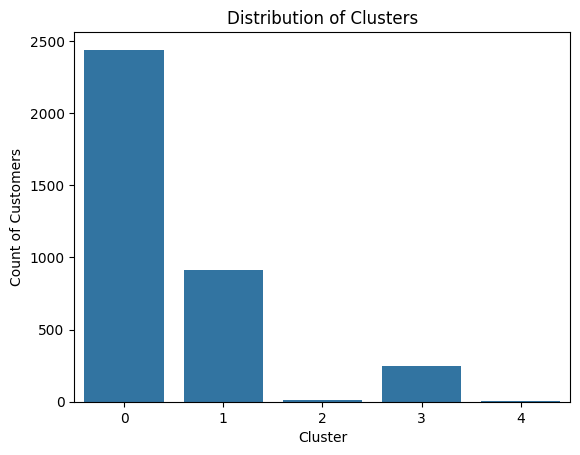

In [111]:
# Lets take a look at how many customers are in each cluster
sns.countplot(x='Cluster', data=rfm)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count of Customers')
plt.show()

In [113]:
# Identifying the center of our clusters 
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['recency', 'frequency', 'monetary'])
print(centroids)

    recency  frequency   monetary
0 -0.498795  -0.162458  -0.124093
1  1.519455  -0.199816  -0.157158
2 -0.599249  12.436778   6.395680
3 -0.668715   1.788332   1.198450
4 -0.725813   2.716685  21.260167


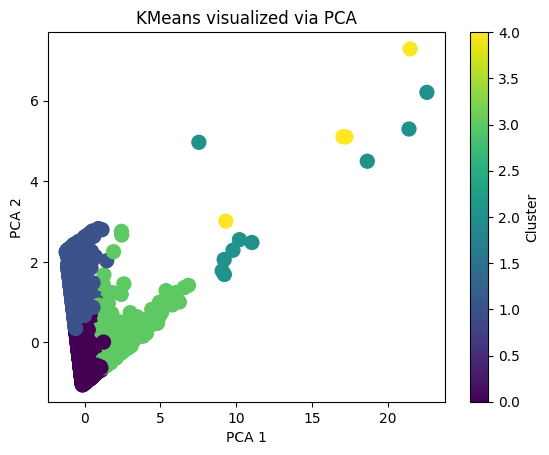

In [115]:
# Using PCA to visualize our clusters in a lower-dimensional space
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

plt.scatter(pca_components[:, 0], pca_components[:, 1], c=kmeans.labels_, cmap='viridis', s=100, marker='o')
plt.title('KMeans visualized via PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

In [117]:
# Customer Behavior:

# Customer 0: Low Engagement/Lost and Dormant Customer
    # Infrequent purchases with below average recency and a low spending mark.

# Customer 1: New Customer/Potential to be Loyal
    # Low spending to pair with a low purchasing frequency. However, above-average recency indicating they are recent customers.

# Customer 2: Loyal Customer
    # High spending (Significantly less than our high-value customers) and high frequency, however have not purchased in some time.

# Customer 3: Moderate Engagement Customer/At Risk to be lost
    # Frequent purchases with above average spending but below average recency. This customer is at risk of being lost as they have not
    # purchased a product in some time.

# Customer 4: High-value Customer
    # Highest spenders with frequent purchases and above average recency. This is our top customer in the dataset, marked by their 
    # consistent purchases of high monetary value.

In [119]:
# Suggestions/Strategies:

# Customer 0: Low Engagement/Lost and Dormant Customer
    # Chose to focus on re-engagement strategies or deallocate resources if they are unlikely to return.

# Customer 1: New Customer/Potential to be Loyal
    # Engage these customers in on-boarding campaigns to encourage continuing purchases and build them into a Loyal Customer.

# Customer 2: Loyal Customer
    # Provide personalized offers to these customers to re-engage them. Incentivize them with free shipping or exclusive products/offers

# Customer 3: Moderate Engagement Customer/At Risk to be lost
    # Engage in re-engagement strategies such as time-limited promotions, special incentives to shop in the next month, 
    # and engagement product emails.

# Customer 4: High-value Customer (VIP)
    # Offer exclusive early access to new products, "VIP only products", and offer discounts associated with customer milestones. 